In [4]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"

# CHAPTER 8. 차원 축소

**차원의 저주**<sup>curse of dimensionality</sup> : 훈련 샘플 각각이 수천 심지어 수백만 개의 특성을 가지고 있어 훈련을 느리게 할 뿐만 아니라, 좋은 솔루션을 찾기 어렵게 만드는 문제

**CAUTION_**
- 차원을 축소시키면 일부 정보가 유실됨
 - 훈련 속도가 빨라질 수는 있지만 시스템의 성능이 조금 나빠질 수 있음
 - 작업 파이프라인이 조금 더 복잡하게 되고 유지 관리가 어려워짐
- 차원 축소를 고려하기 전에 훈련이 너무 느린지 먼저 원본 데이터로 시스템을 훈련시켜 봐야 함
- 어떤 경우에는 훈련 데이터의 차원을 축소시키면 잡음이나 불필요한 세부사항을 걸러내므로 성능을 높일 수 있음(일반적으로는 훈련 속도만 빨라짐)

- 훈련 속도를 높이는 것 외에 차원 축소는 데이터 시각화<sup>data visualization</sup>(또는 Data Viz)에도 아주 유용
- 차원 수를 둘로(또는 셋으로) 줄이면 고차원 훈련 세트를 하나의 그래프로 그릴 수 있고 군집 같은 시각적인 패턴을 감지해 중요한 통찰을 얻는 경우가 많음

---
## 8.1 차원의 저주

- 고차원의 데이터셋에서 훈련 데이터는 서로 멀리 떨어져 있음. 이는 새로운 샘플도 훈련 샘플과 멀리 떨어져 있을 가능성이 높다는 뜻
- 이 경우 예측을 위해 훨씬 많은 외삽<sup>extrapolation</sup>을 해야 하기 때문에 저차원일 때보다 예측이 더 불안정함
- 간단히 말해 훈련 세트의 차원이 클수록 과대적합 위험이 커짐

**외삽**<sup>extrapolation</sup> : 원래의 관찰 범위를 넘어서서 다른 변수와의 관계에 기초하여 변수의 값을 추정하는 과정

- 이론적으로 차원의 저주를 해결하는 해결책 하나는 훈련 샘플의 밀도가 충분히 높아질 때까지 훈련 세트의 크기를 키우는 것
- 실제로는 일정 밀도에 도달하기 위해 필요한 훈련 샘플 수는 차원 수가 커짐에 따라 기하급수적으로 늘어남

---
## 8.2 차원 축소를 위한 접근 방법

차원을 감소시키는 두 가지 주요한 접근법인 투영<sup>projection</sup>과 매니폴드 학습<sup>Manifold Learning</sup>을 살펴보겠습니다.

### 8.2.1 투영

- 대부분의 훈련 샘플이 모든 차원에 걸쳐 균일하게 퍼져 있지 않음
- 많은 특성은 거의 변화가 없는 반면, 다른 특성들은 서로 강하게 연관되어 있음
- 결과적으로 모든 훈련 샘플이 고차원 공간 안의 저차원 **부분 공간**<sup>subspace</sup>에 놓여 있음
- 예를 들어 [그림 8-2]에 원 모양을 띤 3차원 데이터셋이 있음

<img src="./images/Figure8-2.png" width="60%">
<center>**그림 8-2 2차원에 가깝게 배치된 3차원 데이터셋**</center>

- 여기서 모든 훈련 샘플을 이 부분 공간에 수직으로(즉, 샘플과 평면 사이의 가장 짧은 직선을 따라) 투영하면 [그림 8-3]과 같은 2D 데이터셋을 얻음
- 데이터셋의 차원을 3D에서 2D로 줄였음

<img src="./images/Figure8-3.png" width="45%">
<center>**그림 8-3 투영하여 만들어진 새로운 2D 데이터셋**</center>

- 차원 축소에 있어서 투영이 언제나 최선의 방법은 아님
- 많은 경우 [그림 8-4]에 표현된 **스위스 롤**<sup>Swiss roll</sup> 데이터셋처럼 부분 공간이 뒤틀리거나 휘어 있기도 함

<img src="./images/Figure8-4.png" width="50%">
<center>**그림 8-4 스위스 롤 데이터셋**</center>

- 그냥 평면에 투영시키면(예를 들면 x<sub>3</sub>를 버리고) [그림 8-5]의 왼쪽처럼 스위스 롤의 층이 서로 뭉개짐
- 우리가 원하는 것은 스위스 롤을 펼쳐서 오른쪽처럼 2D 데이터셋을 얻는 것임

<img src="./images/Figure8-5.png" width="90%">
<center>**그림 8-5 평면에 그냥 투영시켜서 뭉개진 것(왼쪽)과 스위스 롤을 펼쳐놓은 것(오른쪽)**</center>

### 8.2.2 매니폴드 학습

- 스위스 롤은 2D **매니폴드**의 한 예. 2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D 모양
- 일반적으로 d차원 매니폴드는 국부적으로 d차원 초평면으로 볼일 수 있는 n차원 공간의 일부(d < n)
- 스위스 롤의 경우에는 d=2이고 n=3. 국부적으로는 2D 평면으로 보이지만 3차원으로 말려 있음

- 많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 **매니폴드**를 모델링하는 식으로 작동함
- 이를 **매니폴드 학습**<sup>Manifold Learning</sup>이라고 함
- 이는 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 **매니폴드 가정**<sup>manifold assumption</sup> 또는 **매니폴드 가설**<sup>manifold hypothesis</sup>에 근거함

- MNIST 데이터셋으로 생각해보면 손글씨 숫자 이미지는 선으로 연결되어 있고 경계는 흰색이고 어느 정도 중앙에 있음
- 이미지 중 아주 적은 일부만 손글씨 숫자처럼 보임
- 이런 제약은 데이터셋을 저차원의 매니폴드로 압축할 수 있도록 도와줌

- 매니폴드 가정은 종종 암묵적으로 다른 가정과 병행되곤 함. 바로 처리해야 할 작업(예를 들면 분류나 회귀)이 저차원의 매니폴드 공간에 표현되면 더 간단해질 것이란 가정임
- 예를 들어 [그림 8-6]의 첫 번째 행에서는 스위스 롤이 두 개의 클래스로 나뉘어 있음
- 3D(왼쪽)에서는 결정 경계가 매우 복잡하지만 펼쳐진 매니폴드 공간인 2D(오른쪽)에서는 결정 경계가 단순한 직선임

- 이런 가정이 항상 유효하지는 않음
- [그림 8-6]의 두 번째 행의 경우에는 결정 경계가 x<sub>1</sub> = 5에 놓여 있음
- 이 결정 경계는 3D 공간에서는 매우 단순함(수직 평면). 하지만 펼쳐진 매니폴드에서는 결정 경계가 더 복잡해짐(네 개의 독립된수직선)

<img src="./images/Figure8-6.png" width="80%">
<center>**그림 8-6 저차원에서 항상 간단하지 않은 결정 경계**</center>

- 요약하면 모델을 훈련시키기 전에 훈련 세트의 차원을 감소시키면 훈련 속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는 것은 아님
- 이는 전적으로 데이터셋에 달렸음

---
## 8.3 PCA

**주성분 분석**<sup>Principal Component Analysis</sup>(PCA) : 가장 인기 있는 차원 축소 알고리즘. 먼저 데이터에 가장 가까운 초평면<sup>hyperplane</sup>을 정의한 다음, 데이터를 이 평면에 투영시킴

### 8.3.1 분산 보존

- 저차원의 초평면에 훈련 세트를 투영하기 전에 먼저 올바른 초평면을 선택해야 함
- 예를 들어 [그림 8-7]의 왼쪽 그래프는 간단한 2D 데이터셋이 세 개의 축(즉, 일차원 초평면)과 함께 표현되어 있음. 오른쪽 그래프는 데이터셋이 각 축에 투영된 결과
 - 실선에 투영된 것은 분산을 최대로 보존하는 반면, 점선에 투영된 것은 분산을 매우 적게 유지하고 있음

<img src="./images/Figure8-7.png" width="80%">
<center>**그림 8-7 투영할 부분 공간 선택하기**</center>

- 분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적으로 보임
- 이 선택을 다른 방식으로 설명하면 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화하는 축임

### 8.3.2 주성분

- PCA는 훈련 세트에서 분산이 최대인 축을 찾음. 또한 첫 번째 축에 직교하고 남은 분산을 최대한 보존하는 두 번째 축을 찾음
- 고차원 데이터셋이라면 PCA는 이전의 두 축에 직교하는 세 번째 축을 찾으며 데이터셋에 있는 차원의 수만큼 네 번째, 다섯 번째, ... 축을 찾음
- i번째 축을 정의하는 단위 벡터를 i번째 **주성분**<sup>principal component</sup>(PC)이라고 부름. [그림 8-7]에서 1번째 PC는 c<sub>1</sub>이고 2번째 PC는 c<sub>2</sub>

**NOTE_** 주성분의 방향은 일정치 않음. 훈련 세트를 조금 섞은 다음 다시 PCA를 적용하면 새로운 PC 중 일부가 원래 PC와 반대 방향일 수 있음

- 훈련 세트의 주성분을 찾는 방법
 - 특잇값 분해<sup>Singular Value Decomposition</sup>(SVD)라는 표준 행렬 분해 기술을 사용
 - 훈련 세트 행렬 X를 세 개 행렬의 점곱인 U&middot;&Sigma;&middot;V<sup>T</sup>로 분해
 - 여기서 찾고자 하는 모든 주성분이 V에 [식 8-1]과 같이 담겨 있음

<img src="./images/Equation8-1.png" width="30%">
<center>**식 8-1 주성분 행렬**</center>

다음 파이썬 코드는 넘파이의 svd() 함수를 사용해 훈련 세트의 모든 주성분을 구한 후 처음 두 개의 PC를 추출

3D 데이터셋을 만듭니다:

In [10]:
np.random.seed(4) # 난수 생성을 위한 시드 설정
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [26]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]
c1

array([0.93636116, 0.29854881, 0.18465208])

In [27]:
c2

array([-0.34027485,  0.90119108,  0.2684542 ])

In [28]:
Vt

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ],
       [-0.08626012, -0.31420255,  0.94542898]])

**CAUTION_** PCA는 데이터셋의 평균이 0이라고 가정함. 사이킷런의 PCA 파이썬 클래스는 이 작업을 대신 처리해줌.<br>
그러나 (앞의 코드처럼) PCA를 직접 구현하거나 다른 라이브러리를 사용한다면 먼저 데이터를 원점에 맞추는 것을 잊어서는 안 됨

### 8.3.3 d차원으로 투영하기

- 주성분을 모두 추출해냈다면 처음 d개의 주성분으로 정의한 초평면에 투영하여 데이터셋의 차원을 d차원으로 축소시킬 수 있음.
- 이 초평면은 분산을 가능한 한 최대로 보존하는 투영임을 보장함
- 예를 들어 [그림 8-2]에서 3D 데이터셋은 데이터셋의 분산이 가장 큰 첫 두 개의 주성분으로 구성된 2D 평면에 투영됨

- 초평면에 훈련 세트를 투영하기 위해서는 [식 8-2]와 같이 행렬 X와 첫 d개의 주성분을 담은 (즉, V의 첫 d열로 구성된) 행렬 W<sub>d</sub>를 점곱하면 됨

<img src="./images/Equation8-2.png" width="20%">
<center>**식 8-2 훈련 세트를 d차원으로 투영하기**</center>

다음 파이썬 코드는 첫 두 개의 주성분으로 정의된 평면에 훈련 세트를 투영함

In [29]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

PCA 변환이 되었음. 지금까지 분산을 가능한 한 최대로 유지하면서 어떻게 데이터셋의 차원을 특정 차원으로 축소하는지 보았음

### 8.3.4 사이킷런 사용하기

- 사이킷런의 PCA 모델은 앞서 한 것처럼 SVD 분해 방법을 사용하여 구현함

다음은 PCA 모델을 사용해 데이터셋의 차원을 2로 줄이는 코드 (사이킷런의 PCA 모델은 자동으로 데이터를 중앙에 맞춰줌)

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [44]:
print(X.shape)
X[:5]

(60, 3)


array([[-1.01570027, -0.55091331, -0.26132626],
       [-0.00771675,  0.59958572,  0.03507755],
       [-0.95317135, -0.46453691, -0.24920288],
       [-0.92012304,  0.21009593,  0.02182381],
       [-0.76309739,  0.158261  ,  0.19152496]])

In [45]:
print(X2D.shape)
X2D[:5]

(60, 2)


array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

PCA 변환기를 데이터셋에 학습시키고 나면 components_ 변수를 사용해 주성분을 확인할 수 있음

In [38]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

### 8.3.5 설명된 분산의 비율

**설명된 분산의 비율**<sup>explained variance ratio</sup> : explained_variance\_ratio_ 변수에 저장된 유용한 정보중 하나로 이 값은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타냄

In [46]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

이는 데이터셋 분산의 84.2%가 첫 번째 축에 놓여 있고 14.6%가 두 번째 축에 놓여 있음을 알려줌

### 8.3.6 적절한 차원 수 선택하기

- 축소할 차원 수를 임의로 정하기보다는 충분한 분산(예를 들면 95%)이 될 때까지 더해야 할 차원 수를 선택하는 쪽을 더 선호함
- 데어터 시각화를 위해 차원을 축소하는 경우에는 차원을 2개나 3개로 줄이는 것이 일반적

다음 코드는 차원을 축소하지 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수를 계산함

In [114]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

mnist = fetch_mldata('MNIST original')

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

/anaconda3/envs/mlbook/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/envs/mlbook/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [52]:
pca = PCA()
pca.fit(X_train)
# np.cumsum 함수는 입력 배열의 원소를 차례대로 누적한 배열을 반환
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [53]:
d

154

그런 다음 n_components=d로 설정하여 PCA를 다시 실행함.<br>
하지만 유지하려는 주성분의 수를 지정하기보다는 보존하려는 분산의 비율을 n_components에 0.0에서 1.0사이로 설정하는 편이 훨씬 좋음

In [54]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [58]:
X_train.shape

(52500, 784)

In [56]:
X_reduced.shape

(52500, 154)

- 적절한 차원 수를 선택하는 또 다른 방법은 설명된 분산을 차원 수에 대한 함수로 그리는 것([그림 8-8])<br>
 이 그래프에는 설명된 분산의 빠른 성장이 멈추는 변곡점이 있음. 여기서는 차원을 약 100으로 축소해도 설명된 분산을 크게 손해보지 않을 것

<img src="./images/Figure8-8.png" width="50%">
<center>**그림 8-8 차원 수에 대한 함수로 나타낸 설명된 분산**</center>

### 8.3.7 압축을 위한 PCA

- 차원을 축소하고 난 후에는 훈련 세트의 크기가 줄어듦
- 또한 압축된 데이터셋에 PCA 투영의 변환을 반대로 적용하여 되돌릴 수도 있음. 물론 투영에서 일정량의 정보를 잃어버렸기 때문에 이렇게 해도 원본 데이터셋을 얻을 수는 없음
- 원본 데이터와 재구성된 데이터(압축 후 원복한 것) 사이의 평균 제곱 거리를 **재구성 오차**<sup>reconstruction error</sup>라고 함

다음 코드는 MNIST 데이터셋을 154차원으로 압축하고 inverse_transform() 메서드를 사용해 784차원으로 복원함<br>
[그림 8-9]는 원본 훈련 세트와 샘플을 압축한 후 복원한 결과를 보여줌

In [115]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [116]:
X_reduced.shape

(52500, 154)

In [117]:
X_recovered.shape

(52500, 784)

<img src="./images/Figure8-9.png" width="50%">
<center>**그림 8-9 분산의 95%가 유지된 MNIST 압축**</center>

역변환 공식은 [식 8-3]과 같음

<img src="./images/Equation8-3.png" width="30%">
<center>**식 8-3 원본의 차원 수로 되돌리는 PCA 역변환**</center>

### 8.3.8 점진적 PCA

- PCA 구현의 문제는 SVD<sup>Singular Value Decomposition</sup> 알고리즘(특잇값 분해)을 실행하기 위해 전체 훈련 세트를 메모리에 올려야 한다는 것이지만<br>
**점진적 PCA**<sup>Incremental PCA</sup>(IPCA) 알고리즘이 있음
- 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입함. 이런 방식은 훈련 세트가 클 때 유용하고 온라인으로(즉, 새로운 데이터가 준비되는 대로 실시간으로) PCA를 적용할 수도 있음

다음 코드는 MNIST 데이터셋을 (넘파이의 array_split() 함수를 사용해) 100개의 미니배치로 나누고<br> 사이킷런의 IncrementalPCA 파이썬 클래스에 주입하여 MNIST 데이터셋의 차원을 (이전과 같은) 154개로 줄임.<br>
전체 훈련 세트를 사용하는 fit() 메서드가 아니라 partial_fit() 메서드를 미니배치마다 호출해야 함

In [63]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [118]:
X_train.shape

(52500, 784)

In [119]:
X_reduced.shape

(52500, 154)

또 다른 방법은 넘파이의 memmap 파이썬 클래스를 사용해 하드 디스크의 이진 파일에 저장된 매우 큰 배열을 메모리에 들어 있는 것처럼 다루는 것.<br>
이 파이썬 클래스는 필요할 때 데이터를 메모리에 적재함. IncrementalPCA는 특정 순간에 배열의 일부만 사용하기 때문에 메모리 부족 문제를 해결함.<br>
다음 코드처럼 이 방식을 적용하면 일반적인 fit() 메서드를 사용할 수 있음

memmap() 구조를 만들고 MNIST 데이터를 복사합니다. 이는 일반적으로 별도의 프로그램에서 먼저 수행됩니다:

In [72]:
from tempfile import mkdtemp
import os.path as path
filename = path.join(mkdtemp(), 'newfile.dat')
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

이제 memmap() 객체를 삭제하면 파이썬 종결자(finalizer)를 호출해서 데이터를 디스크에 저장하게 됩니다.

In [73]:
del X_mm

다음에 다른 프로그램에서 데이터를 로드하여 훈련에 사용합니다:

In [74]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

### 8.3.9 랜덤 PCA

- **랜덤 PCA**<sup>Randomized PCA</sup> : 확률적인 알고리즘으로, 첫 d개의 주성분에 대한 근삿값을 빠르게 찾음. 이 알고리즘의 계산 복잡도는<br> O(m &times; n<sup>2</sup>) + O(n<sup>3</sup>)이 아니라 O(m &times; d<sup>2</sup>) + O(d<sup>3</sup>)임. 그래서 d가 n보다 많이 작으면 앞선 알고리즘보다 매우 빨라짐

In [75]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

---
## 8.4 커널 PCA

- **커널 PCA**<sup>kernel PCA</sup>(kPCA) : 복잡한 비선형 투영으로의 차원 축소를 가능하게 하는 기법.<br>
이 기법은 투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때 유용

다음 코드는 사이킷런의 KernelPCA를 사용해 RBF 커널로 kPCA를 적용하고 있음

In [80]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

In [81]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

함수 K(a,b) = (a<sup>T</sup>&middot;b)<sup>2</sup> 을 2차 **다항식 커널**이라고 부름<br>
머신러닝에서 **커널**은 변환함수 $\phi$를 계산하지 않고(또는 $\phi$를 모르더라도) 원래 벡터 a와 b에 기반하여 점곱 $\phi$(a)<sup>T</sup>&middot;$\phi$(b)를 계산할 수 있는 함수<br>
[식 5-10]에 가장 널리 사용되는 커널의 일부를 나열함

<img src="./images/Equation5-10.png" width="50%">
<center>**식 5-10 일반적인 커널**</center>

위 네 개의 커널이 매개변수 kernel에 지정할 수 있는 함수<br>
선형은 "linear", 다항식은 "poly", 가우시안 RBF는 "rbf", 시그모이드는 "sigmoid"로 지정함

[그림 8-10]은 선형 커널, RBF 커널, 시그모이드(로지스틱) 커널을 사용하여 2차원으로 축소시킨 스위스 롤의 모습

<img src="./images/Figure8-10.png" width="70%">
<center>**그림 8-10 여러 가지 커널의 kPCA를 사용해 2D로 축소시킨 스위스 롤**</center>

### 8.4.1 커널 선택과 하이퍼파라미터 튜닝

- kPCA는 비지도 학습이기 때문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없음
- 하지만 차원 축소는 종종 지도 학습의 전처리 단계로 활용되므로 그리드 탐색을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선택할 수 있음

다음 코드는 두 단계의 파이프라인을 만드는데, 먼저 kPCA를 사용해 차원을 2차원으로 축소하고 분류를 위해 로지스틱 회귀를 적용함<br>
그런 다음 파이프라인 마지막 단계에서 가장 높은 분류 정확도를 얻기 위해 GridSearchCV를 사용해 kPCA의 가장 좋은 커널과 gamma 파라미터를 찾음

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver='liblinear'))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRe...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kpca__kernel': ['rbf', 'sigmoid'], 'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [83]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

[그림 8-11]은 스위스 롤의 원본 3D 데이터셋(왼쪽 위)과 RBF 커널의 kPCA를 적용한 2D 데이터셋(오른쪽 위)을 보여줌

<img src="./images/Figure8-11.png" width="60%">
<center>**그림 8-11 커널 PCA와 재구성 원상 오차**</center>

- 커널 트릭 덕분에 훈련 세트를 **특성 맵**<sup>feature map</sup> $\varphi$를 사용한 무한 차원의 특성 공간(오른쪽 아래)에 매핑한 다음,<br> 변환된 데이터셋을 선형 PCA를 사용해 2D로 투영한 것과 수학적으로 동일
- 축소된 공간에 있는 샘플에 대해 선형 PCA를 역전시키면 재구성된 데이터 포인트는 원본 공간이 아닌 특성 공간에 놓이게 됨(예를 들어 그림에서 x로 표현한 것)
- 이 특성 공간은 무한 차원이기 때문에 재구성된 포인트를 계산할 수 없고 재구성에 따른 실제 에러를 계산할 수 없음
- 하지만 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트를 찾을 수 있음. 이를 **재구성 원상**<sup>pre-image</sup>이라고 부름
- 원상을 얻게 되면 원본 샘플과의 제곱 거리를 측정할 수 있음. 그래서 재구성 원상의 오차를 최소화하는 커널과 하이퍼파라미터를 선택할 수 있음
- 재구성을 하는 한 가지 방법은 투영된 샘플을 훈련 세트로, 원본 샘플을 타깃으로 하는 지도 학습 회귀 모델을 훈련시키는 것<br>
사이킷런에서는 다음 코드와 같이 fit_inverse_transform = True로 지정하면 이를 자동으로 수행함

In [84]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

**NOTE_** KernelPCA는 fit_inverse_transform = False가 기본값이며 inverse_transform() 메서드를 가지고 있지 않음<br>
&emsp;&emsp;&emsp;&emsp; 이 메서드는 fit_inverse_transform = True를 지정했을 때만 생성됨

그런 다음 재구성 원상 오차를 계산할 수 있음

In [85]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.7863087957661

---
## 8.5 LLE

- **지역 선형 임베딩**<sup>Locally Linear Embedding</sup>(LLE) : 또 다른 강력한 **비선형 차원 축소**<sup>nonlinear dimensionality reduction</sup>(NLDR) 기술<br>
이전 알고리즘처럼 투영에 의존하지 않는 매니폴드 학습
- LLE는 먼저 각 훈련 샘플이 가장 가까운 이웃<sup>closest neighbor</sup>(c.n.)에 얼마나 선형적으로 연관되어 있는지 측정함.<br>
그런 다음 국부적인 관계가 가장 잘 보존되는 훈련 세트의 저차원 표현을 찾음. 이는 특히 잡음이 너무 많지 않은 경우 꼬인 매니폴드를 펼치는데 잘 작동함

다음 코드는 사이킷런의 LocallyLinearEmbedding을 사용해 스위스 롤을 펼침

In [86]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

결과 2D 데이터셋이 [그림 8-12]에 나타나 있음

<img src="./images/Figure8-12.png" width="50%">
<center>**그림 8-12 LLE를 사용하여 펼쳐진 스위스 롤**</center>

- 그림에서 볼 수 있듯이 스위스 롤이 완전히 펼쳐졌고 지역적으로는 샘플 간 거리가 잘 보존되어 있음
- 그러나 크게 보면 샘플 간 거리가 잘 유지되어 있지 않음. 펼쳐진 스위스 롤의 오른쪽은 압축되어 있고 왼쪽은 확장되어 있음
- 그럼에도 불구하고 LLE는 매니폴드를 모델링하는 데 잘 동작함

- LLE가 작동하는 방식
 - 먼저 알고리즘이 각 훈련 샘플 x<sup>(i)</sup>에 대해 가장 가까운 k개의 샘플을 찾음(앞 코드에서는 k=10)
 - 그런 다음 이 이웃에 대한 선형 함수로 x<sup>(i)</sup>를 재구성함
 - 이는 x<sup>(i)</sup>와 $\textstyle \sum_{j=1}^m w_{i,j}x^{(j)}$ 사이의 제곱 거리가 최소가 되는 w<sub>i,j</sub>를 찾는 것
 - 여기서 x<sup>(j)</sup>가 x<sup>(i)</sup>의 가장 가까운 k개 이웃 중 하나가 아닐 경우에는 w<sub>i,j</sub> = 0이 됨
 - 그러므로 LLE의 첫 단계는 [식 8-4]와 같은 제한이 있는 최적화 문제가 됨
 - 여기서 W는 가중치 w<sub>i,j</sub>를 모두 담고 있는 가중치 행렬. 두 번째 제약은 각 훈련 샘플 x<sup>(i)</sup>에 대한 가중치를 단순히 정규화하는 것

<img src="./images/Equation8-4.png" width="50%">
<center>**식 8-4 LLE 단계 1: 선형적인 지역 관계 모델링**</center>

- LLE가 작동하는 방식(이어서)
 - 이 단계를 거치면 (가중치 $\hat w_{i,j}$를 담고 있는) 가중치 행렬 $\hat W$은 훈련 샘플 사이에 있는 지역 선형 관계를 담고 있음
 - 이제 두 번째 단계는 가능한 한 이 관계가 보존되도록 훈련 샘플을 d차원 공간(d<n)으로 매핑함
 - 만약 z<sup>(i)</sup>가 d차원 공간에서 x<sup>(i)</sup>의 상<sup>image</sup>이라면 가능한 한 z<sup>(i)</sup>와 $\textstyle \sum_{j=1}^m w_{i,j}z^{(j)}$ 사이의 거리가 최소화되어야 함
 - 이 아이디어는 [식 8-5]와 같은 제약이 없는 최적화 문제로 바꾸어줌
 - 첫 번째 단계와 비슷해 보이지만, 샘플을 고정하고 최적의 가중치를 찾는 대신, 반대로 가중치를 고정하고 저차원의 공간에서 샘플 이미지의 최적 위치를 찾음
 - Z는 모든 z<sup>(i)</sup>를 포함하는 행렬임

<img src="./images/Equation8-5.png" width="30%">
<center>**식 8-5 LLE 단계 2: 관계를 보존하는 차원 축소**</center>

- 사이킷런이 제공하는 LLE 구현의 계산 복잡도
 - k개의 가장 가까운 이웃을 찾는 데 -> O(m log(m) n log(k))
 - 가중치 최적화 -> O(mnk<sup>3</sup>)
 - 저차원 표현을 만드는 데 -> O(dm<sup>2</sup>)
- 마지막 항의 m<sup>2</sup> 때문에 이 알고리즘을 대량의 데이터셋에 적용하기는 어려움

---
## 8.6 다른 차원 축소 기법

사이킷런은 다양한 차원 축소 기법을 제공함. 다음은 그중에서 가장 널리 사용되는 것들임([그림 8-13])

- **다차원 스케일링**<sup>Multidimensional Scaling</sup>(MDS) : 샘플 간의 거리를 보존하면서 차원을 축소함
- **Isomap** : 각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만듦. 그런 다음 샘플 간의 **지오데식 거리**<sup>geodesic distance</sup>를 유지하면서 차원을 축소함<br>
그래프에서 두 노드 사이의 **지오데식 거리**는 두 노드 사이의 최단 경로를 이루는 노드의 수
- **t-SNE**<sup>t-Distributed Stochastic Neighbor Embedding</sup> : 비슷한 샘플은 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 하면서 차원을 축소함.<br> 주로 시각화에 많이 사용되며 특히 고차원 공간에 있는 샘플의 군집을 시각화할 때 사용됨(예를 들면 MNIST 데이터셋을 2D로 시각화 할 때)
- **선형 판별 분석**<sup>Linear Discriminant Analysis</sup>(LDA) :<br> 분류 알고리즘이지만 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습함. 이 축은 데이터가 투영되는 초평면을 정의하는데 사용할 수 있음.<br> 이 알고리즘의 장점은 투영을 통해 가능한 한 클래스를 멀리 떨어지게 유지시키므로 SVM 분류기 같은 다른 분류 알고리즘을 적용하기 전에 차원을 축소시키는데 좋음

<img src="./images/Figure8-13.png" width="70%">
<center>**그림 8-13 여러 가지 기법을 사용해 스위스 롤을 2D로 축소하기**</center>

---
## 8.7 연습문제

1.데이터셋의 차원을 축소하는 주요 목적은 무엇인가요? 대표적인 단점은 무엇인가요?

- 차원 축소의 주요 목적
 - 훈련 알고리즘의 속도를 높이기 위해(어떤 경우에는 잡음과 중복된 특성을 삭제할 수도 있어 훈련 알고리즘의 성능을 높임)
 - 데이터를 시각화하고 가장 중요한 특성에 대한 통찰을 얻기 위해
 - 메모리 공간을 절약하기 위해(압축)
- 주요 단점
 - 일부 정보를 잃어버려 훈련 알고리즘의 성능을 감소시킬 수 있음
 - 계산 비용이 높음
 - 머신러닝 파이프라인의 복잡도를 증가시킴
 - 변환된 데이터를 이해하기 어려운 경우가 많음

---
2.차원의 저주란 무엇인가요?

- 저차원 공간에는 없는 많은 문제가 고차원 공간에서 일어난다는 사실을 뜻함
- 고차원 벡터는 매우 희소해서 과대적합의 위험이 크고, 많은 양의 데이터가 있지 않으면 데이터에 있는 패턴을 잡아내기가 매우 어려움

---
3.데이터셋의 차원을 축소시키고 나서 이 작업을 원복할 수 있나요? 할 수 있다면 어떻게 가능할까요? 가능하지 않다면 왜일까요?

- 데이터셋의 차원이 축소되면 일부 정보가 차원 축소 과정에서 사라지기 때문에 이를 완벽하게 되돌리는 것은 불가능함

---
4.매우 비선형적인 데이터셋의 차원을 축소하는 데 PCA를 사용할 수 있을까요?

- PCA는 불필요한 차원을 제거할 수 있기 때문에 매우 비선형적이더라도 대부분의 더이터셋에서 차원을 축소하는데 사용할 수 있음
- 그러나 불필요한 차원이 없다면 PCA의 차원 축소는 너무 많은 정보를 잃게 만듦

---
5.설명된 분산을 95%로 지정한 PCA를 1,000개의 차원을 가진 데이터셋에 적용한다고 가정하겠습니다. 결과 데이터셋의 차원은 얼마나 될까요?

- 답은 데이터셋에 따라 다름. 극단적인 두 가지 사례를 살펴보겠음
- 먼저 거의 완벽하게 일렬로 늘어선 데이터 포인트로 구성된 데이터셋을 생각해보면, PCA는 분산의 95%를 유지하면서 데이터셋을 단 하나의 차원으로 줄일 수 있음
- 이번에는 완전히 무작위로 1,000개의 차원에 걸쳐 흩어져 있는 데이터셋을 생각해보면, 이 경우 분산의 95%를 보존하려면 거의 950개의 차원이 필요할 것임
- 그러므로 답은 데이터셋에 따라 달라지고 1에서 950 사이의 어떤 수도 될 수 있음

---
6.기본 PCA, 점진적 PCA, 랜덤 PCA, 커널 PCA는 어느 경우에 사용될까요?

- **기본 PCA** : 우선적으로 사용되지만 데이터셋 크기가 메모리에 맞을 때에 가능함
- **점진적 PCA** : 메모리에 담을 수 없는 대용량 데이터셋에 적합. 하지만 기본 PCA보다 느리므로 데이터셋이 메모리 크기에 맞으면 기본 PCA를 사용해야 함. <br>점진적 PCA는 새로운 샘플이 발생될 때마다 실시간으로 PCA를 적용해야 하는 온라인 작업에 사용 가능함
- **랜덤 PCA** : 데이터셋이 메모리 크기에 맞고 차원을 크게 축소시킬 때 사용됨. 이 경우에는 기본 PCA보다 훨씬 빠름
- **커널 PCA** : 비선형 데이터셋에 유용함

---
7.어떤 데이터셋에 적용한 차원 축소 알고리즘의 성능을 어떻게 평가할 수 있을까요?

- 직관적으로 데이터셋에서 너무 많은 정보를 잃지 않고 차원을 많이 제거할 수 있다면 차원 축소 알고리즘이 잘 작동한 것
- 이를 측정하는 한 가지 방법은 역변환을 수행해서 재구성 오차를 측정하는 것
- 하지만 모든 차원 축소 알고리즘이 역변환을 제공하지는 않음
- 만약 차원 축소를 다른 머신러닝 알고리즘(예를 들면 랜덤 포레스트 분류기)을 적용하기 전에 전처리 단계로 사용한다면 두 번째 알고리즘의 성능을 측정해볼 수 있음.<br>
즉, 차원 축소가 너무 많은 정보를 잃지 않았다면 원본 데이터셋을 사용했을 때와 비슷한 성능이 나와야 함

---
8.두 개의 차원 축소 알고리즘을 연결할 수 있을까요?

- 두 개의 차원 축소 알고리즘을 연결할 수 있음
- PCA로 불필요한 차원을 대폭 제거하고 난 다음 LLE 같이 훨씬 느린 알고리즘을 적용하는 것이 대표적인 사례
- 이런 2단계 방식은 LLE만 사용했을 때와 거의 비슷한 성능을 내지만 속도가 몇 분의 1로 줄어들 것

---
9.(3장에서 소개한) MNIST 데이터셋을 로드하고 훈련 세트와 테스트 세트로 분할합니다(처음 60,000개는 훈련을 위한 샘플이고 나머지 10,000개는 테스트용입니다). 이 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 시간을 잰 다음, 테스트 세트로 만들어진 모델을 평가합니다. 그런 다음 PCA를 사용해 설명된 분산이 95%가 되도록 차원을 축소합니다. 이 축소된 데이터셋에 새로운 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 확인합니다. 훈련 속도가 더 빨라졌나요? 이제 테스트 세트에서 이 분류기를 평가해보세요. 이전 분류기와 비교해서 어떤가요?

문제: (3장에서 소개한) MNIST 데이터셋을 로드하고 훈련 세트와 테스트 세트로 분할합니다(처음 60,000개는 훈련을 위한 샘플이고 나머지 10,000개는 테스트용입니다).

In [87]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [88]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

문제: 이 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 시간을 잰 다음, 테스트 세트로 만들어진 모델을 평가합니다.

In [89]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)

In [90]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [91]:
print("훈련 시간 {:.2f}s".format(t1 - t0))

훈련 시간 6.36s


In [92]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9492

문제: 그런 다음 PCA를 사용해 설명된 분산이 95%가 되도록 차원을 축소합니다.

In [93]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

문제: 이 축소된 데이터셋에 새로운 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 확인합니다. 훈련 속도가 더 빨라졌나요?

In [94]:
rnd_clf2 = RandomForestClassifier(n_estimators=10, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [95]:
print("훈련 시간 {:.2f}s".format(t1 - t0))

훈련 시간 9.87s


훈련이 느려졌습니다! 이 장에서 보았듯이 차원 축소는 언제나 훈련 시간을 줄여주지 못합니다. 데이터셋, 모델, 훈련 알고리즘에 따라 달라집니다.

문제: 이제 테스트 세트에서 이 분류기를 평가해보세요. 이전 분류기와 비교해서 어떤가요?

In [96]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9009

차원 축소를 했을 때 유용한 정보를 일부 잃었기 때문에 성능이 조금 감소되는 것이 일반적입니다. 그렇지만 이 경우에는 성능 감소가 좀 심각한 것 같습니다. PCA가 별로 도움이 되지 않네요. 훈련 시간도 느려지고 성능도 감소했습니다.

---
10.t-SNE 알고리즘을 사용해 MNIST 데이터셋을 2차원으로 축소시키고 맷플롯립으로 그래프를 그려보세요. 이미지의 타깃 클래스마다 10가지 색깔로 나타낸 산점도를 그릴 수 있습니다. 또는 샘플의 위치에 각기 다른 색깔의 숫자를 나타낼 수도 있고, 숫자 이미지 자체의 크기를 줄여서 그릴 수도 있습니다(모든 숫자를 다 그리면 그래프가 너무 복잡해지므로 무작위로 선택한 샘플만 그리거나, 인접한 곳에 다른 샘플이 그려져 있지 않은 경우에만 그립니다). 잘 분리된 숫자의 군집을 시각화할 수 있을 것입니다. PCA, LLE, MDS 같은 차원 축소 알고리즘을 적용해보고 시각화 결과를 비교해보세요.

MNIST 데이터셋을 (다시) 로드합니다:

In [97]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int)

전체 60,000개의 이미지에 차원 축소를 하면 매우 오랜 시간이 걸리므로 10,000개의 이미지만 무작위로 선택하여 사용하겠습니다:

In [98]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

이제 t-SNE를 사용해 2D로 차원을 축소해 그래프로 나타냅니다:

In [99]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

산점도를 그리기 위해 맷플롯립의 scatter() 함수를 사용합니다. 각 숫자마다 다른 색깔을 사용합니다:

/anaconda3/envs/mlbook/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


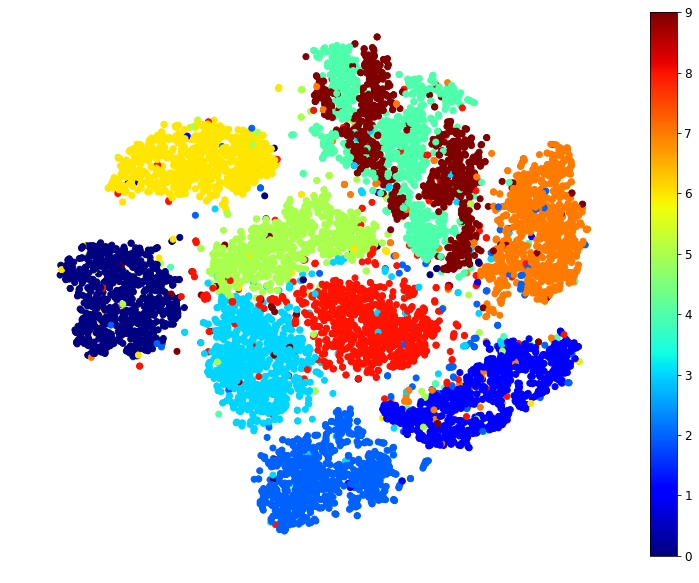

In [100]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

이 그래프는 어떤 숫자가 다른 것과 구분이 쉬운지 알려 줍니다(가령, 0, 6 등이 잘 구분되어 있습니다). 그리고 어떤 숫자가 구분이 어려운지 알려 줍니다(가령, 4, 9입니다).

PCA부터 시작해 보죠. 얼마나 오래 걸리는지도 재어 보겠습니다:

PCA 시간: 0.3s.


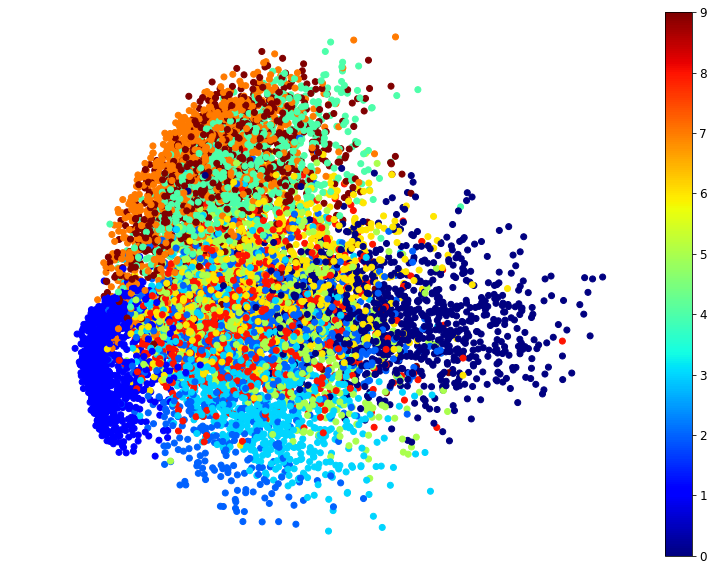

In [108]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA 시간: {:.1f}s.".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

PCA가 아주 빠르네요! 몇 개의 군집이 보이지만 너무 겹쳐져 있습니다. LLE를 사용해 보죠:

LLE 시간: 124.0s.


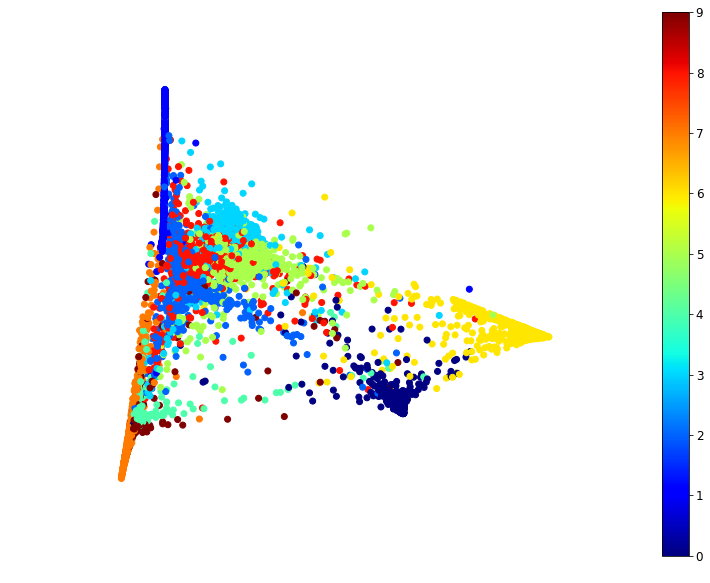

In [107]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE 시간: {:.1f}s.".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_lle_reduced[:, 0], X_lle_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

시간이 좀 걸리고 결과도 아주 좋지는 않습니다.<br>
MDS를 시도해 보죠. 10,000개 샘플을 적용하면 이 알고리즘은 너무 오래걸리므로 2,000개만 시도해 보겠습니다:

MDS 시간: 115.4s (10,000개가 아니고 2,000 MNIST 이미지에서).


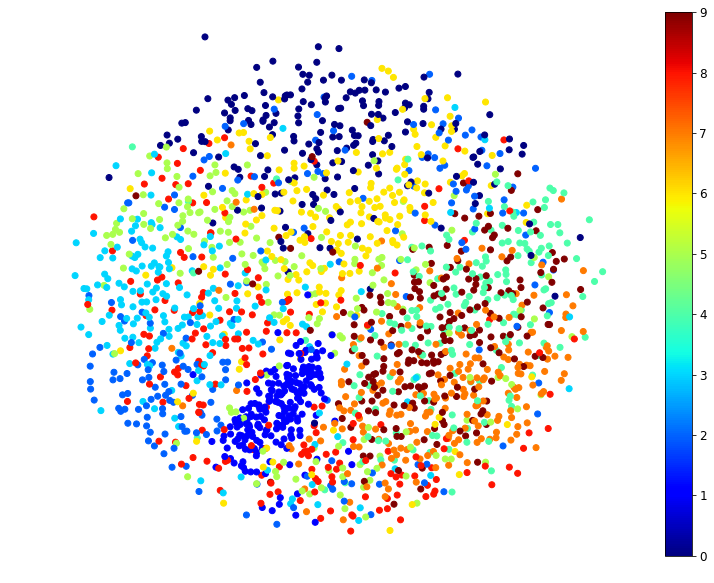

In [106]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS 시간: {:.1f}s (10,000개가 아니고 2,000 MNIST 이미지에서).".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_mds_reduced[:, 0], X_mds_reduced[:, 1], c=y[:m], cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

아 이건 좋지 않아 보이네요. 모든 군집이 너무 중복되어 있습니다. 

아마 이 비교에서 t-SNE가 승자같네요. 시간을 재어 보진 않았으니 한번 해보죠:

t-SNE 시간: 283.9s.


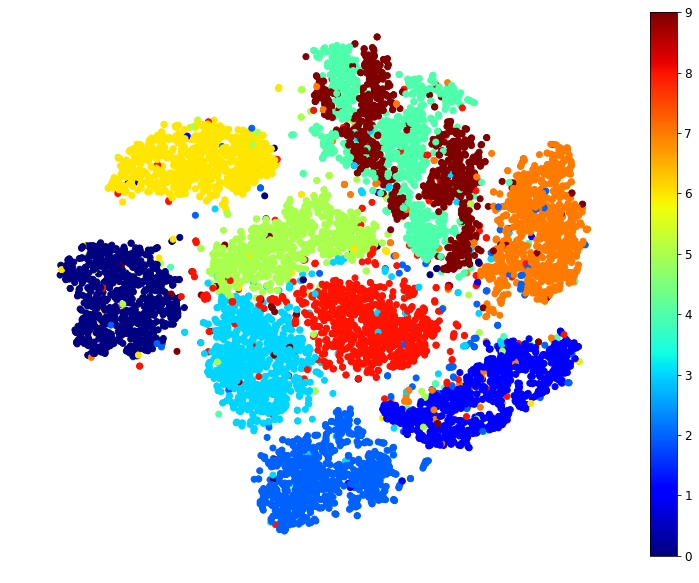

In [109]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE 시간: {:.1f}s.".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

분산의 95%를 보존하도록 먼저 PCA를 적용하면 속도를 높여줄 수 있는지 확인해 보겠습니다:

PCA+t-SNE 시간 151.4s.


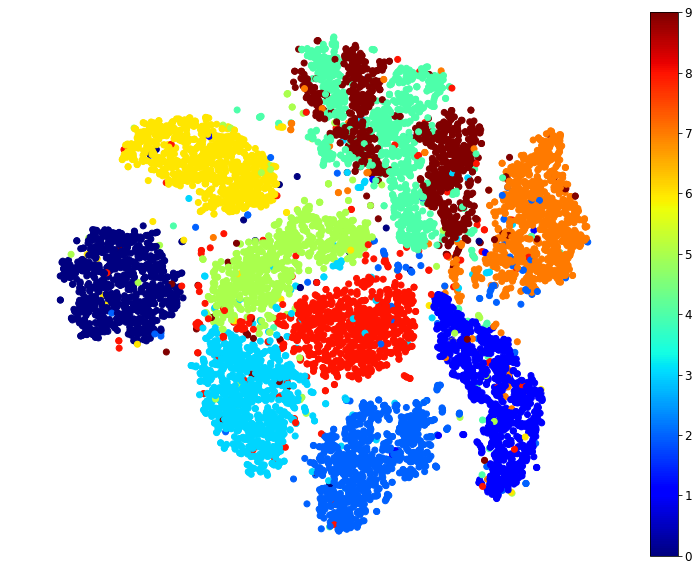

In [110]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE 시간 {:.1f}s.".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_pca_tsne_reduced[:, 0], X_pca_tsne_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

네, 결과물에 영향을 미치지 않으면서 PCA 속도가 향상되었습니다. 